In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [43]:
data=pd.read_csv("cleaned_toll_data.csv")
data.head()

,slno.,merchant_name,direction,lane,tag_id,vehicle_regn_number,txn_amount,initiated_time,inn_rr_time_sec,vehicle_class_code,vehicle_comvehicle,geocode,merchant_sub_type,city,state,inn_rr_time_min
0,1,Bannerghatta Road (P2) Plaza,S,P2BX2,HXYUH,YFUNB,225,21:54,994,VC4,F,"12.850056,77.588333",State,Bengaluru,Karnataka,16.566667
1,2,Bannerghatta Road (P2) Plaza,S,P2BX2,JGEFQ,GQHLZ,225,18:59,4528,VC20,T,"12.850056,77.588333",State,Bengaluru,Karnataka,75.466667
2,3,Bannerghatta Road (P2) Plaza,S,P2BX2,VOAPH,DNTMI,150,00:14,134,VC5,F,"12.850056,77.588333",State,Bengaluru,Karnataka,2.233333
3,4,Kadathanamale Toll Plaza,S,LANE09,XBANK,ZMAOY,35,18:19,80,VC20,F,"13.2123515,77.5535138",State,Bangalore,Karnataka,1.333333
4,5,Kadathanamale Toll Plaza,S,LANE10,HMWDZ,IDSRZ,20,15:03,64,VC4,F,"13.2123515,77.5535138",State,Bangalore,Karnataka,1.066667


In [44]:
!pip install torch_geometric

In [45]:
import torch
import torch_geometric
from torch_geometric.nn import GCNConv, GATConv
from torch_geometric.data import Data

class TrafficGNN(torch.nn.Module):
    def __init__(self, num_node_features, hidden_channels):
        super(TrafficGNN, self).__init__()
        # Graph Attention layer to weight different routes
        self.conv1 = GATConv(num_node_features, hidden_channels)
        self.conv2 = GATConv(hidden_channels, hidden_channels)
        # Output layer to predict congestion scores
        self.linear = torch.nn.Linear(hidden_channels, 1)

    def forward(self, x, edge_index, edge_attr):
        # Apply graph convolutions
        x = self.conv1(x, edge_index, edge_attr)
        x = torch.relu(x)
        x = self.conv2(x, edge_index, edge_attr)
        x = torch.relu(x)

        # Predict congestion score for each node
        congestion_scores = self.linear(x)
        return congestion_scores

In [46]:
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
from torch_geometric.nn import GATConv
from torch_geometric.data import Data, DataLoader
import networkx as nx
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import datetime
import time
import heapq
from tqdm import tqdm

In [47]:
import pandas as pd

def load_and_preprocess_data(file_path):
    print("Loading and preprocessing data...")

    # Load data
    df = pd.read_csv(file_path)

    # Convert timestamp to full datetime
    df['initiated_time'] = pd.to_datetime(df['initiated_time'], errors='coerce')


    # Extract hour, day of the week, and is_weekend features
    df['hour'] = df['initiated_time'].dt.hour
    df['day_of_week'] = df['initiated_time'].dt.dayofweek
    df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)

    # Convert commercial vehicle flag
    df['vehicle_commercial'] = (df['vehicle_class_code'] == 'T').astype(int)

    try:
        # Split geocode by comma instead of space
        df[['latitude', 'longitude']] = df['geocode'].str.split(',', expand=True).astype(float)
    except Exception as e:
        # Fallback for geocode parsing
        print(f"Warning: Geocode parsing failed due to {e}. Using placeholder coordinates.")

        df['latitude'] = pd.to_numeric(df['geocode'].str.extract(r'(\d+\.\d+)')[0], errors='coerce')
        df['longitude'] = pd.to_numeric(df['geocode'].str.extract(r',(\d+\.\d+)')[0], errors='coerce')

        # If longitude is still NaN, set it as latitude + 0.01 (fallback)
        df['longitude'].fillna(df['latitude'] + 0.01, inplace=True)

    # Encode categorical features
    direction_dummies = pd.get_dummies(df['direction'], prefix='direction')
    lane_dummies = pd.get_dummies(df['lane'], prefix='lane')

    # Merge encoded features
    df = pd.concat([df, direction_dummies, lane_dummies], axis=1)

    return df

file_path = "cleaned_toll_data.csv"
df = load_and_preprocess_data(file_path)
print(df.head())


Loading and preprocessing data...


<ipython-input-47-bc0aaa5f3268>:10: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['initiated_time'] = pd.to_datetime(df['initiated_time'], errors='coerce')


   slno.                 merchant_name direction    lane tag_id  \
0      1  Bannerghatta Road (P2) Plaza         S   P2BX2  HXYUH   
1      2  Bannerghatta Road (P2) Plaza         S   P2BX2  JGEFQ   
2      3  Bannerghatta Road (P2) Plaza         S   P2BX2  VOAPH   
3      4      Kadathanamale Toll Plaza         S  LANE09  XBANK   
4      5      Kadathanamale Toll Plaza         S  LANE10  HMWDZ   

  vehicle_regn_number  txn_amount      initiated_time  inn_rr_time_sec  \
0               YFUNB         225 2025-02-25 21:54:00              994   
1               GQHLZ         225 2025-02-25 18:59:00             4528   
2               DNTMI         150 2025-02-25 00:14:00              134   
3               ZMAOY          35 2025-02-25 18:19:00               80   
4               IDSRZ          20 2025-02-25 15:03:00               64   

  vehicle_class_code vehicle_comvehicle                geocode  \
0                VC4                  F    12.850056,77.588333   
1               VC20

In [48]:
pd.set_option("display.max_columns", None)  # Show all columns
print(df.head())


   slno.                 merchant_name direction    lane tag_id  \
0      1  Bannerghatta Road (P2) Plaza         S   P2BX2  HXYUH   
1      2  Bannerghatta Road (P2) Plaza         S   P2BX2  JGEFQ   
2      3  Bannerghatta Road (P2) Plaza         S   P2BX2  VOAPH   
3      4      Kadathanamale Toll Plaza         S  LANE09  XBANK   
4      5      Kadathanamale Toll Plaza         S  LANE10  HMWDZ   

  vehicle_regn_number  txn_amount      initiated_time  inn_rr_time_sec  \
0               YFUNB         225 2025-02-25 21:54:00              994   
1               GQHLZ         225 2025-02-25 18:59:00             4528   
2               DNTMI         150 2025-02-25 00:14:00              134   
3               ZMAOY          35 2025-02-25 18:19:00               80   
4               IDSRZ          20 2025-02-25 15:03:00               64   

  vehicle_class_code vehicle_comvehicle                geocode  \
0                VC4                  F    12.850056,77.588333   
1               VC20

In [49]:
df.head().T

,0,1,2,3,4
slno.,1,2,3,4,5
merchant_name,Bannerghatta Road (P2) Plaza,Bannerghatta Road (P2) Plaza,Bannerghatta Road (P2) Plaza,Kadathanamale Toll Plaza,Kadathanamale Toll Plaza
direction,S,S,S,S,S
lane,P2BX2,P2BX2,P2BX2,LANE09,LANE10
tag_id,HXYUH,JGEFQ,VOAPH,XBANK,HMWDZ
...,...,...,...,...,...
lane_P7X1,False,False,False,False,False
lane_P7X2,False,False,False,False,False
lane_P7X3,False,False,False,False,False
lane_P7X4,False,False,False,False,False


In [50]:
def create_time_windows(df, window_size_minutes=30):
    print("Creating time windows...")
    # Round timestamps to the nearest window
    df['time_window'] = df['initiated_time'].dt.floor(f'{window_size_minutes}min')

    # Calculate metrics per window and location
    agg_data = df.groupby(['direction', 'lane', 'time_window']).agg(
        vehicle_count=('tag_id', 'count'),
        avg_txn_amount=('txn_amount', 'mean'),
        commercial_vehicle_count=('vehicle_commercial', 'sum'),
        avg_time_diff=('initiated_time', lambda x: x.sort_values().diff().mean().total_seconds() if len(x) > 1 else 0)
    ).reset_index()

    # Fill NaN values
    agg_data = agg_data.fillna(0)

    # Calculate congestion score
    agg_data['congestion_score'] = (agg_data['vehicle_count'] * agg_data['avg_time_diff']) / 60

    return agg_data

agg_data=create_time_windows(df)
create_time_windows(df)

Creating time windows...
Creating time windows...


,direction,lane,time_window,vehicle_count,avg_txn_amount,commercial_vehicle_count,avg_time_diff,congestion_score
0,E,00,2025-02-25 00:00:00,4,78.750000,0,120.000000,8.000000
1,E,00,2025-02-25 00:30:00,2,187.500000,0,1380.000000,46.000000
2,E,00,2025-02-25 01:00:00,2,207.500000,0,840.000000,28.000000
3,E,00,2025-02-25 02:00:00,1,115.000000,0,0.000000,0.000000
4,E,00,2025-02-25 03:30:00,1,155.000000,0,0.000000,0.000000
...,...,...,...,...,...,...,...,...
5668,W,LANE5,2025-02-25 21:30:00,29,85.517241,0,62.142857,30.035714
5669,W,LANE5,2025-02-25 22:00:00,31,143.387097,0,58.000000,29.966667
5670,W,LANE5,2025-02-25 22:30:00,35,93.285714,0,51.176470,29.852941
5671,W,LANE5,2025-02-25 23:00:00,48,123.125000,0,37.021276,29.617021


In [51]:
pd.set_option("display.max_columns", None)  # Show all columns
print(df.head())

   slno.                 merchant_name direction    lane tag_id  \
0      1  Bannerghatta Road (P2) Plaza         S   P2BX2  HXYUH   
1      2  Bannerghatta Road (P2) Plaza         S   P2BX2  JGEFQ   
2      3  Bannerghatta Road (P2) Plaza         S   P2BX2  VOAPH   
3      4      Kadathanamale Toll Plaza         S  LANE09  XBANK   
4      5      Kadathanamale Toll Plaza         S  LANE10  HMWDZ   

  vehicle_regn_number  txn_amount      initiated_time  inn_rr_time_sec  \
0               YFUNB         225 2025-02-25 21:54:00              994   
1               GQHLZ         225 2025-02-25 18:59:00             4528   
2               DNTMI         150 2025-02-25 00:14:00              134   
3               ZMAOY          35 2025-02-25 18:19:00               80   
4               IDSRZ          20 2025-02-25 15:03:00               64   

  vehicle_class_code vehicle_comvehicle                geocode  \
0                VC4                  F    12.850056,77.588333   
1               VC20

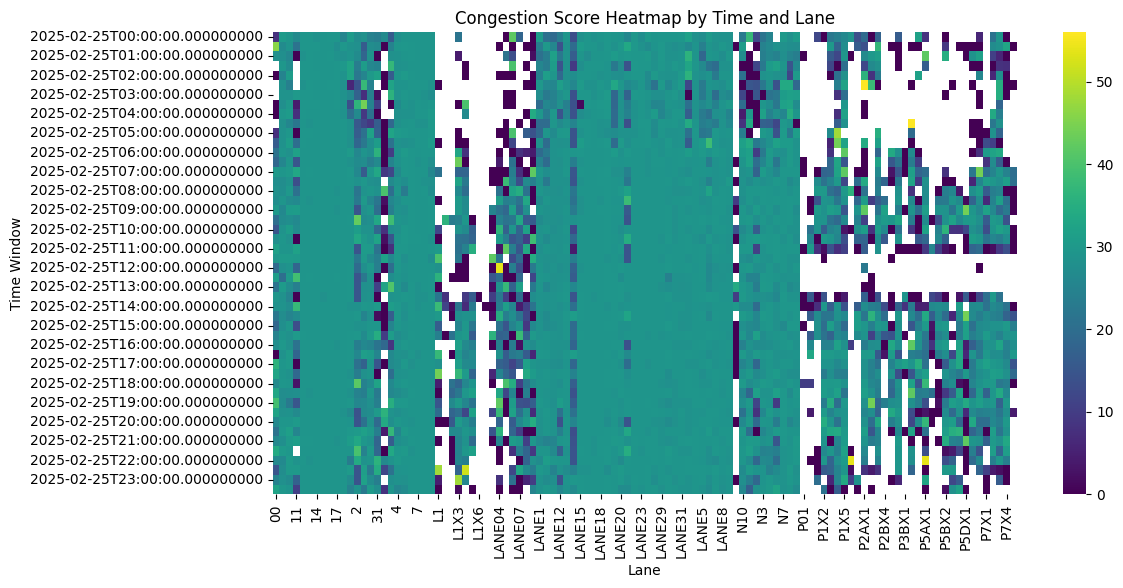

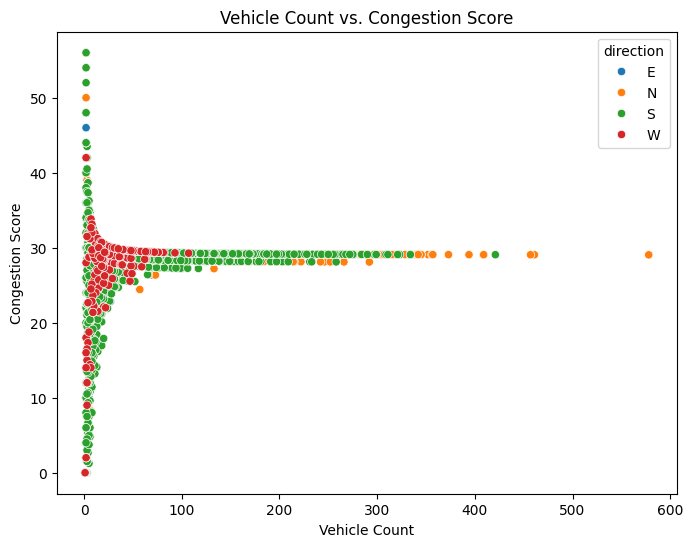

In [52]:


import seaborn as sns
import matplotlib.pyplot as plt


# Example 2: Heatmap of Congestion Score by Time and Lane
plt.figure(figsize=(12, 6))
heatmap_data = agg_data.pivot_table(index='time_window', columns='lane', values='congestion_score')
sns.heatmap(heatmap_data, cmap='viridis', annot=False)
plt.title('Congestion Score Heatmap by Time and Lane')
plt.xlabel('Lane')
plt.ylabel('Time Window')
plt.show()

# Example 3: Scatterplot of Vehicle Count vs Congestion Score
plt.figure(figsize=(8, 6))
sns.scatterplot(x='vehicle_count', y='congestion_score', data=agg_data, hue='direction')
plt.title('Vehicle Count vs. Congestion Score')
plt.xlabel('Vehicle Count')
plt.ylabel('Congestion Score')
plt.show()


In [53]:
def build_traffic_graph(df, agg_data):
    print("Building traffic graph...")
    # Create a directed graph
    G = nx.DiGraph()

    # Add nodes (toll plazas/locations)
    unique_locations = df[['direction', 'latitude', 'longitude']].drop_duplicates()
    for idx, row in unique_locations.iterrows():
        G.add_node(row['direction'],
                  latitude=row['latitude'],
                  longitude=row['longitude'])

    # Add edges based on vehicle movements
    for tag_id, group in tqdm(df.groupby('tag_id')):
        # Sort by timestamp to get the sequence of locations visited
        sorted_group = group.sort_values('initiated_time')

        # Create edges between consecutive locations
        for i in range(len(sorted_group) - 1):
            source = sorted_group.iloc[i]['direction']
            target = sorted_group.iloc[i+1]['direction']

            # Calculate travel time between source and target
            time_diff = (sorted_group.iloc[i+1]['initiated_time'] -
                         sorted_group.iloc[i]['initiated_time']).total_seconds() / 60

            # Add edge if not already present, or update weight
            if G.has_edge(source, target):
                # Update with running average of travel times
                current_count = G[source][target]['count']
                current_time = G[source][target]['travel_time']
                new_time = (current_time * current_count + time_diff) / (current_count + 1)
                G[source][target]['travel_time'] = new_time
                G[source][target]['count'] += 1
            else:
                G.add_edge(source, target, travel_time=time_diff, count=1)

    return G, unique_locations
G,unique_locations = build_traffic_graph(df,agg_data)
build_traffic_graph(df,agg_data)



Building traffic graph...


100%|██████████| 268230/268230 [03:45<00:00, 1191.44it/s]


Building traffic graph...


100%|██████████| 268230/268230 [04:06<00:00, 1086.13it/s]


(<networkx.classes.digraph.DiGraph at 0x798573eac090>,
        direction   latitude  longitude
 0              S  12.850056  77.588333
 3              S  13.212352  77.553514
 10             N  13.212352  77.553514
 155            S  12.857833  77.527583
 488            S  12.846150  77.671765
 489            N  12.846150  77.671765
 499            S  13.042389  77.475278
 847            S  12.989944  77.472444
 1194           E  12.846150  77.671765
 2542           N  13.114638  77.374630
 2543           S  13.114638  77.374630
 2754           S  12.858667  77.655833
 2814           N  12.850056  77.588333
 13206          S  13.193545  77.649810
 13208          N  13.193545  77.649810
 13892          N  12.989944  77.472444
 14812          N  12.858667  77.655833
 18526          N  13.042389  77.475278
 37577          S  13.090678  77.399788
 37580          N  13.090678  77.399788
 37665          S  12.903583  77.470028
 39677          S  12.936583  77.531500
 81347          N  12.776

In [54]:
def prepare_gnn_data(G, agg_data, unique_locations):
    print("Preparing GNN data...")
    # Create node feature matrix
    node_list = list(G.nodes())
    num_nodes = len(node_list)
    node_index = {node: i for i, node in enumerate(node_list)}

    # Create node features
    node_features = np.zeros((num_nodes, 5))

    for node in node_list:
        idx = node_index[node]
        node_agg = agg_data[agg_data['direction'] == node]

        if not node_agg.empty:
            node_features[idx, 0] = node_agg['congestion_score'].mean()
            node_features[idx, 1] = node_agg['vehicle_count'].mean()
            total_vehicles = node_agg['vehicle_count'].sum()
            comm_vehicles = node_agg['commercial_vehicle_count'].sum()
            node_features[idx, 2] = comm_vehicles / total_vehicles if total_vehicles > 0 else 0

        # Add location features
        loc_data = unique_locations[unique_locations['direction'] == node]
        if not loc_data.empty:
            node_features[idx, 3] = loc_data.iloc[0]['latitude']
            node_features[idx, 4] = loc_data.iloc[0]['longitude']

    # Normalize node features
    scaler = StandardScaler()
    node_features = scaler.fit_transform(node_features)

    # Create edge index and edge features
    edge_index = []
    edge_attr = []

    for source, target, data in G.edges(data=True):
        source_idx = node_index[source]
        target_idx = node_index[target]
        edge_index.append([source_idx, target_idx])

        # Edge attributes: travel time and count
        edge_attr.append([data['travel_time'], data['count']])

    # Convert to torch tensors
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    edge_attr = torch.tensor(edge_attr, dtype=torch.float)
    node_features = torch.tensor(node_features, dtype=torch.float)

    # Create target: congestion score for each node
    y = torch.tensor([agg_data[agg_data['direction'] == node]['congestion_score'].mean()
                     for node in node_list], dtype=torch.float).view(-1, 1)

    # Create PyTorch Geometric data object
    data = Data(x=node_features, edge_index=edge_index, edge_attr=edge_attr, y=y)

    return data, node_index, node_list, scaler
data, node_index, node_list, scaler=prepare_gnn_data(G, agg_data, unique_locations)
prepare_gnn_data(G, agg_data, unique_locations)

Preparing GNN data...
Preparing GNN data...


(Data(x=[4, 5], edge_index=[2, 16], edge_attr=[16, 2], y=[4, 1]),
 {'S': 0, 'N': 1, 'E': 2, 'W': 3},
 ['S', 'N', 'E', 'W'],
 StandardScaler())

In [55]:
class TrafficGNN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(TrafficGNN, self).__init__()
        self.conv1 = GATConv(in_channels, hidden_channels, edge_dim=2)
        self.conv2 = GATConv(hidden_channels, hidden_channels, edge_dim=2)
        self.lin1 = torch.nn.Linear(hidden_channels, hidden_channels)
        self.lin2 = torch.nn.Linear(hidden_channels, out_channels)

    def forward(self, x, edge_index, edge_attr):
        # First Graph Attention layer
        x = self.conv1(x, edge_index, edge_attr)
        x = F.relu(x)
        x = F.dropout(x, p=0.2, training=self.training)

        # Second Graph Attention layer
        x = self.conv2(x, edge_index, edge_attr)
        x = F.relu(x)

        # MLP for final prediction
        x = self.lin1(x)
        x = F.relu(x)
        x = F.dropout(x, p=0.2, training=self.training)
        x = self.lin2(x)

        return x

Training GNN model...
Epoch: 010, Train Loss: 207.2863, Val Loss: 160.9399
Epoch: 020, Train Loss: 16.0266, Val Loss: 52.8298
Epoch: 030, Train Loss: 4.0761, Val Loss: 2.9105
Epoch: 040, Train Loss: 80.7303, Val Loss: 10.7732
Early stopping at epoch 47
Test RMSE: 1.3191


<ipython-input-56-11de136b1a05>:66: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pt'))


Training GNN model...
Epoch: 010, Train Loss: 237.4853, Val Loss: 118.9441
Epoch: 020, Train Loss: 21.8979, Val Loss: 75.9589
Epoch: 030, Train Loss: 10.7249, Val Loss: 1.4187
Epoch: 040, Train Loss: 6.5844, Val Loss: 23.8930
Epoch: 050, Train Loss: 44.3444, Val Loss: 3.7571
Early stopping at epoch 53
Test RMSE: 1.5202


TrafficGNN(
  (conv1): GATConv(5, 64, heads=1)
  (conv2): GATConv(64, 64, heads=1)
  (lin1): Linear(in_features=64, out_features=64, bias=True)
  (lin2): Linear(in_features=64, out_features=1, bias=True)
)

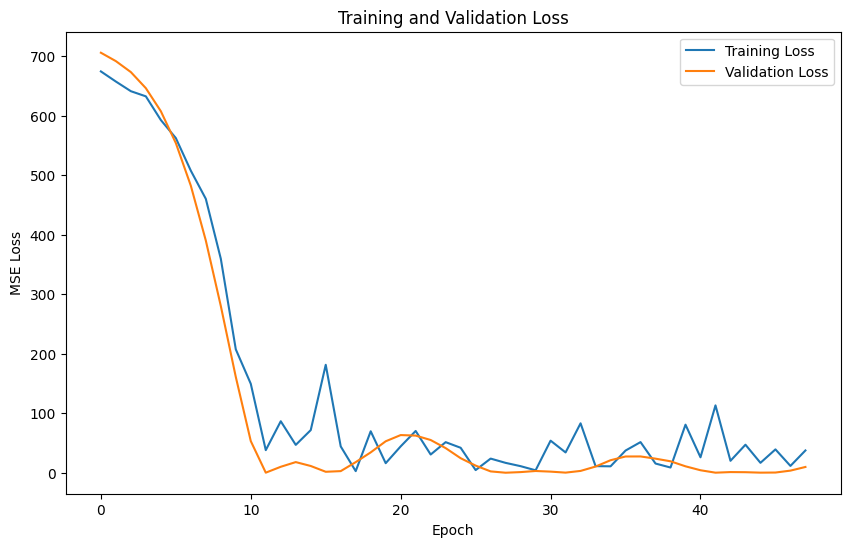

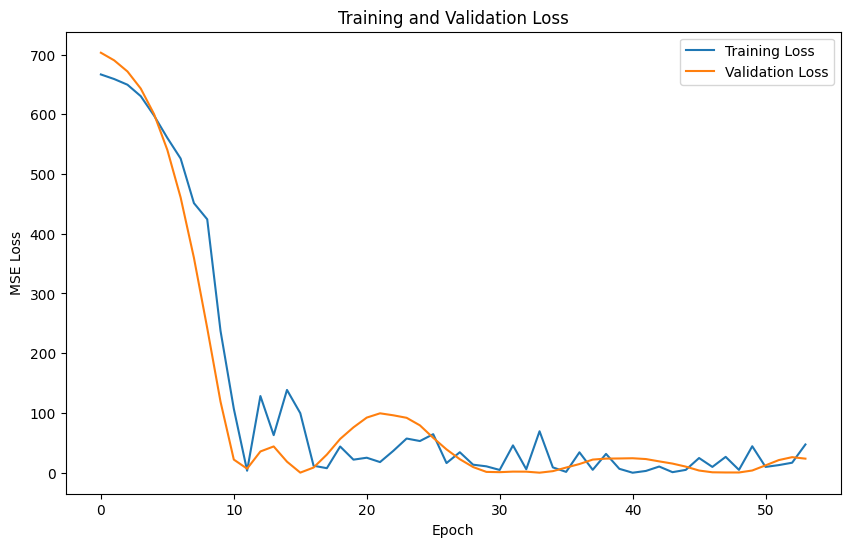

In [56]:
def train_gnn_model(data):
    print("Training GNN model...")
    # Split data into train, validation, and test
    num_nodes = data.x.size(0)
    indices = list(range(num_nodes))

    train_idx, test_idx = train_test_split(indices, test_size=0.2, random_state=42)
    train_idx, val_idx = train_test_split(train_idx, test_size=0.25, random_state=42)

    train_mask = torch.zeros(num_nodes, dtype=torch.bool)
    val_mask = torch.zeros(num_nodes, dtype=torch.bool)
    test_mask = torch.zeros(num_nodes, dtype=torch.bool)

    train_mask[train_idx] = True
    val_mask[val_idx] = True
    test_mask[test_idx] = True

    # Initialize model
    model = TrafficGNN(in_channels=data.x.size(1),
                     hidden_channels=64,
                     out_channels=1)

    # Configure optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

    # Training loop
    best_val_loss = float('inf')
    patience = 20
    patience_counter = 0
    epochs = 200
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        # Training
        model.train()
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.edge_attr)
        loss = F.mse_loss(out[train_mask], data.y[train_mask])
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

        # Validation
        model.eval()
        with torch.no_grad():
            out = model(data.x, data.edge_index, data.edge_attr)
            val_loss = F.mse_loss(out[val_mask], data.y[val_mask])
            val_losses.append(val_loss.item())

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), 'best_model.pt')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch}")
                break

        if (epoch + 1) % 10 == 0:
            print(f'Epoch: {epoch+1:03d}, Train Loss: {loss:.4f}, Val Loss: {val_loss:.4f}')

    # Load best model
    model.load_state_dict(torch.load('best_model.pt'))

    # Test performance
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index, data.edge_attr)
        test_loss = F.mse_loss(out[test_mask], data.y[test_mask])
        test_rmse = torch.sqrt(test_loss)

    print(f'Test RMSE: {test_rmse:.4f}')

    # Plot training curves
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.savefig('training_curve.png')

    return model
model = train_gnn_model(data)
train_gnn_model(data)

In [57]:
class RouteRecommender:
    def __init__(self, G, model, data, node_index, node_list):
        self.G = G
        self.model = model
        self.data = data
        self.node_index = node_index
        self.node_list = node_list

        # Generate congestion predictions
        self.model.eval()
        with torch.no_grad():
            self.congestion_scores = self.model(data.x, data.edge_index, data.edge_attr).numpy().flatten()

    def update_edge_weights(self, commercial_vehicle=False):
        """
        Update edge weights based on predicted congestion and vehicle type
        """
        for u, v, data in self.G.edges(data=True):
            u_idx = self.node_index[u]
            v_idx = self.node_index[v]

            # Base travel time
            travel_time = data['travel_time']

            # Adjust for congestion at destination node
            congestion_factor = 1 + self.congestion_scores[v_idx]

            # Adjust for commercial vehicles if applicable
            comm_penalty = 1.2 if commercial_vehicle and self.data.x[v_idx, 2] > 0.7 else 1.0

            # Calculate final weight
            weight = travel_time * congestion_factor * comm_penalty

            # Update edge weight
            self.G[u][v]['weight'] = weight

    def find_shortest_path(self, source, target, commercial_vehicle=False):
        """
        Find the shortest path from source to target
        """
        # Update edge weights based on current conditions
        self.update_edge_weights(commercial_vehicle)

        # Check if source and target are in the graph
        if source not in self.G or target not in self.G:
            return None, float('inf')

        try:
            # Use Dijkstra's algorithm to find shortest path
            path = nx.shortest_path(self.G, source=source, target=target, weight='weight')
            path_length = nx.shortest_path_length(self.G, source=source, target=target, weight='weight')
            return path, path_length
        except nx.NetworkXNoPath:
            return None, float('inf')
    def find_alternative_routes(self, source, target, commercial_vehicle=False, max_alternatives=3):
        """
        Find multiple alternative routes from source to target
        """
        # Find the shortest path first
        best_path, best_length = self.find_shortest_path(source, target, commercial_vehicle)

        if best_path is None:
            return []

        results = [(best_path, best_length)]

        # Temporarily remove edges from the shortest path to find alternatives
        temp_G = self.G.copy()

        for i in range(max_alternatives):
            # Remove a random edge from the previous best path
            if len(results) > 0 and len(results[-1][0]) > 2:
                path = results[-1][0]

                # Choose a random edge to remove
                idx = np.random.randint(0, len(path) - 1)
                u, v = path[idx], path[idx + 1]

                if temp_G.has_edge(u, v):
                    # Store the edge attributes
                    edge_attr = temp_G[u][v]
                    # Remove the edge
                    temp_G.remove_edge(u, v)

                    try:
                        # Find a new path
                        alt_path = nx.shortest_path(temp_G, source=source, target=target, weight='weight')
                        alt_length = nx.shortest_path_length(temp_G, source=source, target=target, weight='weight')

                        # Only add if sufficiently different
                        path_different = True
                        for existing_path, _ in results:
                            if len(set(alt_path).intersection(set(existing_path))) / len(alt_path) > 0.7:
                                path_different = False
                                break

                        if path_different and alt_length < best_length * 1.5:  # Only consider if not too much longer
                            results.append((alt_path, alt_length))

                    except nx.NetworkXNoPath:
                        # Restore the edge if no alternative path exists
                        temp_G.add_edge(u, v, **edge_attr)

                    # Restore the edge for the next iteration
                    temp_G.add_edge(u, v, **edge_attr)

        # Sort by path length
        results.sort(key=lambda x: x[1])

        return results
    def generate_route_recommendation(self, source, target, commercial_vehicle=False):
        """
        Generate a route recommendation with alternatives
        """
        routes = self.find_alternative_routes(source, target, commercial_vehicle)

        if not routes:
            return {
                "success": False,
                "message": "No route found between the specified locations."
            }

        recommendations = []
        for i, (path, length) in enumerate(routes):
            # Calculate congestion scores along the path
            congestion_points = []
            for node in path:
                idx = self.node_index[node]
                score = self.congestion_scores[idx]
                if score > 0.5:  # Arbitrary threshold for demonstration
                    congestion_points.append(node)

            recommendations.append({
                "route_id": i + 1,
                "path": path,
                "estimated_time": f"{length:.1f} minutes",
                "congestion_points": congestion_points,
                "is_recommended": (i == 0)
            })

        return {
            "success": True,
            "source": source,
            "destination": target,
            "vehicle_type": "Commercial" if commercial_vehicle else "Regular",
            "recommendations": recommendations,
            "timestamp": datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        }
recommender = RouteRecommender(G, model, data, node_index, node_list)
RouteRecommender(G, model, data, node_index, node_list)
locations = list(G.nodes())
if len(locations) >= 2:
    source = locations[0]
    target = locations[-1]
    regular_recommendation = recommender.generate_route_recommendation(source, target, commercial_vehicle=False)
    recommender.generate_route_recommendation(source, target, commercial_vehicle=False)
    commercial_recommendation = recommender.generate_route_recommendation(source, target, commercial_vehicle=True)
    recommender.generate_route_recommendation(source, target, commercial_vehicle=True)


In [58]:
# def main():


#     # Step 5: Train GNN model
#     model = train_gnn_model(data)

#     # Step 6: Create route recommender
#     recommender = RouteRecommender(G, model, data, node_index, node_list)

#     # Step 7: Generate sample recommendations
#     print("\n--- Sample Route Recommendations ---")

#     # Sample source and destination
#     locations = list(G.nodes())
#     if len(locations) >= 2:
#         source = locations[0]
#         target = locations[-1]

#         # Generate recommendation for regular vehicle
#         print("\nRegular Vehicle Route:")
#         regular_recommendation = recommender.generate_route_recommendation(source, target, commercial_vehicle=False)

#         # Generate recommendation for commercial vehicle
#         print("\nCommercial Vehicle Route:")
#         commercial_recommendation = recommender.generate_route_recommendation(source, target, commercial_vehicle=True)



In [59]:
import json  # For pretty-printing JSON output

# Create an instance of RouteRecommender
recommender = RouteRecommender(G, model, data, node_index, node_list)

# Get locations from the graph
locations = list(G.nodes())
print(locations)
# Ensure there are enough locations to find a route
if len(locations) >= 2:
    source = locations[0]
    target = locations[-1]

    # Generate recommendations
    regular_recommendation = recommender.generate_route_recommendation(source, target, commercial_vehicle=False)
    commercial_recommendation = recommender.generate_route_recommendation(source, target, commercial_vehicle=True)

    # Print output directly in Google Colab
    print("🔵 Regular Vehicle Route Recommendation:")
    print(json.dumps(regular_recommendation, indent=4))  # Pretty print JSON output

    print("\n🟠 Commercial Vehicle Route Recommendation:")
    print(json.dumps(commercial_recommendation, indent=4))  # Pretty print JSON output


['S', 'N', 'E', 'W']
🔵 Regular Vehicle Route Recommendation:
{
    "success": true,
    "source": "S",
    "destination": "W",
    "vehicle_type": "Regular",
    "recommendations": [
        {
            "route_id": 1,
            "path": [
                "S",
                "W"
            ],
            "estimated_time": "11058.9 minutes",
            "congestion_points": [
                "S",
                "W"
            ],
            "is_recommended": true
        }
    ],
    "timestamp": "2025-02-25 08:40:05"
}

🟠 Commercial Vehicle Route Recommendation:
{
    "success": true,
    "source": "S",
    "destination": "W",
    "vehicle_type": "Commercial",
    "recommendations": [
        {
            "route_id": 1,
            "path": [
                "S",
                "W"
            ],
            "estimated_time": "11058.9 minutes",
            "congestion_points": [
                "S",
                "W"
            ],
            "is_recommended": true
        }


In [59]:
# Example usage
source_plaza = "BannerghaS"  # Source toll plaza
target_plaza = "ElectronicCity"  # Destination toll plaza
is_commercial = False  # Set to True for commercial vehicles

# Initialize the recommender
recommender = RouteRecommender(G, model, data, node_index, node_list)

# Get route recommendations
recommendations = recommender.generate_route_recommendation(
    source_plaza, target_plaza, commercial_vehicle=is_commercial)

# Display recommendations
for rec in recommendations["recommendations"]:
    print(f"Route {rec['route_id']}: {' -> '.join(rec['path'])}")
    print(f"Estimated Time: {rec['estimated_time']}")
    if rec['congestion_points']:
        print(f"Congestion Points: {', '.join(rec['congestion_points'])}")
    print(f"Recommended: {rec['is_recommended']}")
    print()